In [4]:
# Colab setup: install Gymnasium + classic control + toy text envs
!pip -q install "gymnasium[classic-control,toy-text]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 64.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

import gymnasium as gym


def set_global_seed(seed: int):
    """Make runs more reproducible (still not perfectly deterministic across all systems)."""
    random.seed(seed)
    np.random.seed(seed)


def reset_env(env, seed: int):
    """Gymnasium reset returns (obs, info)."""
    obs, info = env.reset(seed=seed)
    return obs


def step_env(env, action: int):
    """Gymnasium step returns (obs, reward, terminated, truncated, info)."""
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    return obs, reward, done


def moving_average(x, window=20):
    if len(x) < window:
        return np.array(x, dtype=float)
    x = np.array(x, dtype=float)
    return np.convolve(x, np.ones(window) / window, mode="valid")


In [ ]:
def q_learning_discrete(
    env_id: str,
    train_episodes: int = 12000,
    gamma: float = 0.99,
    alpha: float = 0.1,
    eps_start: float = 1.0,
    eps_end: float = 0.05,
    eps_decay: float = 0.999,
    eval_every: int = 1000,
    eval_episodes: int = 300,
    seeds=(0, 1, 2, 3, 4),
    env_kwargs=None
):
    """
    Tabular Q-learning for environments with Discrete observation/action spaces (like FrozenLake, Taxi).
    Returns learning curves and final Q-tables per seed.
    """
    env_kwargs = env_kwargs or {}

    curves = []   # list of dicts (one per seed)
    q_tables = []

    for seed in seeds:
        set_global_seed(seed)
        env = gym.make(env_id, **env_kwargs)

        assert isinstance(env.observation_space, gym.spaces.Discrete), "This function needs discrete states."
        assert isinstance(env.action_space, gym.spaces.Discrete), "This function needs discrete actions."

        nS = env.observation_space.n
        nA = env.action_space.n
        Q = np.zeros((nS, nA), dtype=np.float32)

        eps = eps_start

        eval_x = []
        eval_avg_return = []
        eval_success_rate = []

        # Training
        for ep in range(1, train_episodes + 1):
            s = reset_env(env, seed + ep)  # vary the reset seed per episode
            done = False
            ep_return = 0.0

            while not done:
                # epsilon-greedy action selection
                if random.random() < eps:
                    a = env.action_space.sample()
                else:
                    a = int(np.argmax(Q[s]))

                s_next, r, done = step_env(env, a)
                ep_return += float(r)

                # Q-learning update
                best_next = float(np.max(Q[s_next]))
                td_target = float(r) + gamma * best_next * (0.0 if done else 1.0)
                Q[s, a] += alpha * (td_target - Q[s, a])

                s = s_next

            # decay epsilon once per episode
            eps = max(eps_end, eps * eps_decay)

            # Periodic evaluation (greedy policy: no exploration)
            if ep % eval_every == 0:
                avg_ret, succ = evaluate_greedy_discrete(env_id, Q, eval_episodes, seed + 10_000 + ep, env_kwargs)
                eval_x.append(ep)
                eval_avg_return.append(avg_ret)
                eval_success_rate.append(succ)

        env.close()

        curves.append({
            "seed": seed,
            "x": np.array(eval_x),
            "avg_return": np.array(eval_avg_return),
            "success_rate": np.array(eval_success_rate),
        })
        q_tables.append(Q)

    return curves, q_tables


def evaluate_greedy_discrete(env_id: str, Q: np.ndarray, episodes: int, seed: int, env_kwargs=None):
    """Evaluate a greedy policy (argmax Q) on a discrete env. Returns (avg_return, success_rate)."""
    env_kwargs = env_kwargs or {}
    env = gym.make(env_id, **env_kwargs)

    returns = []
    successes = 0

    rng = np.random.default_rng(seed)

    for _ in range(episodes):
        s = reset_env(env, int(rng.integers(0, 1_000_000)))
        done = False
        ep_return = 0.0

        while not done:
            a = int(np.argmax(Q[s]))
            s, r, done = step_env(env, a)
            ep_return += float(r)

        returns.append(ep_return)
        if ep_return > 0:   # FrozenLake: reaching goal yields reward 1
            successes += 1

    env.close()
    return float(np.mean(returns)), float(successes / episodes)


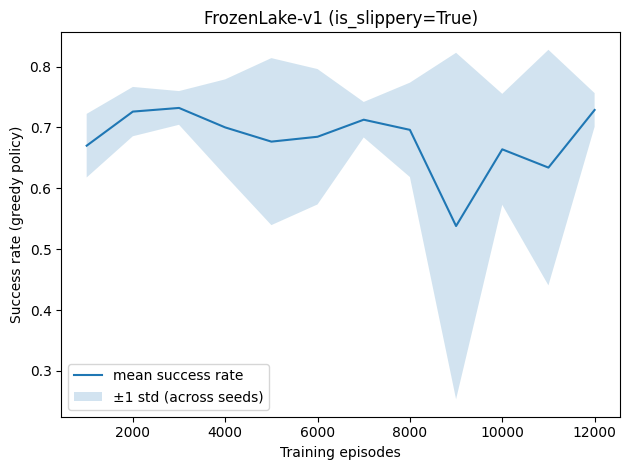

Final success rate (mean ± std): 0.7286666666666667 ± 0.02769677077045463


In [ ]:
# FrozenLake sanity-check baseline
env_id = "FrozenLake-v1"

# "is_slippery=True" is the usual harder/stochastic setting.
# You can flip it to False for debugging (it should learn faster).
env_kwargs = dict(is_slippery=True)

curves_fl, qtables_fl = q_learning_discrete(
    env_id=env_id,
    train_episodes=12000,
    gamma=0.99,
    alpha=0.1,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.999,
    eval_every=1000,
    eval_episodes=300,
    seeds=(0, 1, 2, 3, 4),
    env_kwargs=env_kwargs
)

# Plot mean success rate across seeds
xs = curves_fl[0]["x"]
success_matrix = np.vstack([c["success_rate"] for c in curves_fl])  # shape: [n_seeds, n_points]

mean_succ = success_matrix.mean(axis=0)
std_succ = success_matrix.std(axis=0)

plt.figure()
plt.plot(xs, mean_succ, label="mean success rate")
plt.fill_between(xs, mean_succ - std_succ, mean_succ + std_succ, alpha=0.2, label="±1 std (across seeds)")
plt.xlabel("Training episodes")
plt.ylabel("Success rate (greedy policy)")
plt.title(f"{env_id} (is_slippery={env_kwargs['is_slippery']})")
plt.legend()
plt.tight_layout()
plt.show()

print("Final success rate (mean ± std):", float(mean_succ[-1]), "±", float(std_succ[-1]))


In [1]:
class BoxDiscretizer:
    """
    Turns a continuous Box observation into a single discrete state index using bins.
    This lets you use tabular Q-learning on environments like CartPole.

    Notes:
    - CartPole velocities are effectively unbounded, so we CLIP them to chosen ranges.
    - More bins -> more states -> more data needed (sample complexity).
    """
    def __init__(self, lows, highs, n_bins_per_dim):
        self.lows = np.array(lows, dtype=float)
        self.highs = np.array(highs, dtype=float)
        self.n_bins = np.array(n_bins_per_dim, dtype=int)

        assert self.lows.shape == self.highs.shape == self.n_bins.shape
        assert np.all(self.highs > self.lows)
        assert np.all(self.n_bins >= 2)

        # Precompute strides for flattening multi-dim bins into a single index
        self.strides = np.cumprod(np.concatenate(([1], self.n_bins[:-1])))

    @property
    def n_states(self):
        return int(np.prod(self.n_bins))

    def obs_to_state(self, obs):
        obs = np.array(obs, dtype=float)

        # Clip to chosen ranges (important for velocity dimensions)
        obs = np.clip(obs, self.lows, self.highs)

        # Map each dimension to a bin index [0, n_bins-1]
        ratios = (obs - self.lows) / (self.highs - self.lows)
        bin_ids = (ratios * (self.n_bins - 1)).astype(int)
        bin_ids = np.clip(bin_ids, 0, self.n_bins - 1)

        # Flatten multi-dim bin id into a single integer state
        state = int(np.dot(bin_ids, self.strides))
        return state


In [6]:
def q_learning_cartpole_discretized(
    env_id: str = "CartPole-v1",
    train_episodes: int = 30000,
    gamma: float = 0.99,
    alpha: float = 0.1,
    eps_start: float = 1.0,
    eps_end: float = 0.05,
    eps_decay: float = 0.9995,
    eval_every: int = 2000,
    eval_episodes: int = 200,
    seeds=(0, 1, 2, 3, 4),
    n_bins=(6, 12, 6, 12)
):
    """
    Tabular Q-learning on CartPole via discretisation of the continuous state.
    Returns learning curves + Q tables + discretizer config.
    """
    curves = []
    q_tables = []
    discretizers = []

    for seed in seeds:
        set_global_seed(seed)
        env = gym.make(env_id)

        assert isinstance(env.action_space, gym.spaces.Discrete), "CartPole actions are discrete, good."
        assert isinstance(env.observation_space, gym.spaces.Box), "CartPole observations are continuous (Box)."

        # Use env thresholds for "physically meaningful" position and angle limits
        x_thresh = float(env.unwrapped.x_threshold)
        theta_thresh = float(env.unwrapped.theta_threshold_radians)

        # Velocity and angular velocity are unbounded in theory -> choose practical clip ranges.
        # These are reasonable defaults (assumption), tweak if needed.
        xdot_clip = 3.0
        thetadot_clip = 3.5

        lows = [-x_thresh, -xdot_clip, -theta_thresh, -thetadot_clip]
        highs = [ x_thresh,  xdot_clip,  theta_thresh,  thetadot_clip]

        disc = BoxDiscretizer(lows, highs, n_bins_per_dim=n_bins)
        discretizers.append(disc)

        nA = env.action_space.n
        Q = np.zeros((disc.n_states, nA), dtype=np.float32)

        eps = eps_start

        eval_x = []
        eval_avg_return = []
        eval_success_rate = []  # success = episode return >= 195 (classic CartPole threshold)

        for ep in range(1, train_episodes + 1):
            obs = reset_env(env, seed + ep)
            s = disc.obs_to_state(obs)

            done = False
            ep_return = 0.0

            while not done:
                # epsilon-greedy
                if random.random() < eps:
                    a = env.action_space.sample()
                else:
                    a = int(np.argmax(Q[s]))

                obs_next, r, done = step_env(env, a)
                s_next = disc.obs_to_state(obs_next)

                ep_return += float(r)

                # Q-learning update
                best_next = float(np.max(Q[s_next]))
                td_target = float(r) + gamma * best_next * (0.0 if done else 1.0)
                Q[s, a] += alpha * (td_target - Q[s, a])

                s = s_next

            eps = max(eps_end, eps * eps_decay)

            if ep % eval_every == 0:
                avg_ret, succ = evaluate_greedy_cartpole(env_id, Q, disc, eval_episodes, seed + 10_000 + ep)
                eval_x.append(ep)
                eval_avg_return.append(avg_ret)
                eval_success_rate.append(succ)

        env.close()

        curves.append({
            "seed": seed,
            "x": np.array(eval_x),
            "avg_return": np.array(eval_avg_return),
            "success_rate": np.array(eval_success_rate),
        })
        q_tables.append(Q)

    return curves, q_tables, discretizers


def evaluate_greedy_cartpole(env_id: str, Q: np.ndarray, disc: BoxDiscretizer, episodes: int, seed: int):
    env = gym.make(env_id)
    returns = []
    successes = 0

    rng = np.random.default_rng(seed)

    for _ in range(episodes):
        obs = reset_env(env, int(rng.integers(0, 1_000_000)))
        s = disc.obs_to_state(obs)

        done = False
        ep_return = 0.0

        while not done:
            a = int(np.argmax(Q[s]))
            obs, r, done = step_env(env, a)
            s = disc.obs_to_state(obs)
            ep_return += float(r)

        returns.append(ep_return)
        if ep_return >= 195:  # common "solved" threshold (CartPole-v1 style)
            successes += 1

    env.close()
    return float(np.mean(returns)), float(successes / episodes)


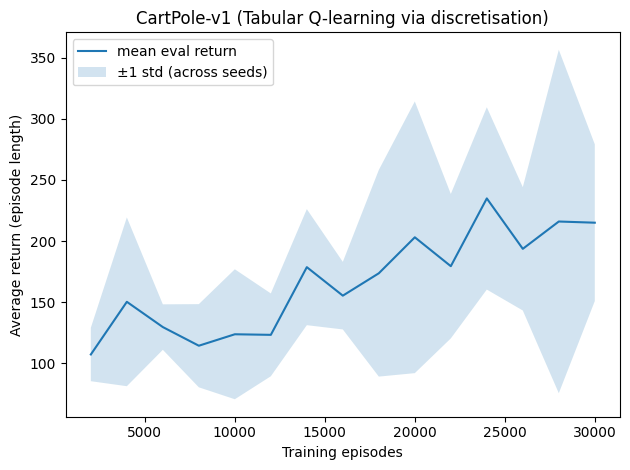

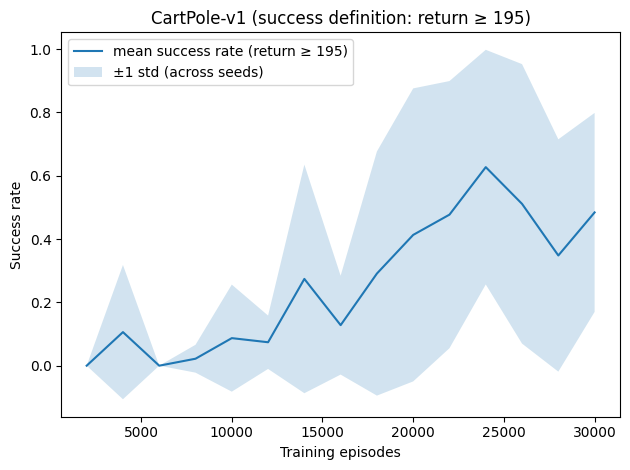

Final CartPole avg return (mean ± std): 215.064 ± 64.05894850838563
Final CartPole success rate (mean ± std): 0.484 ± 0.3142514916432379
Discretised state count: 5184


In [7]:
curves_cp, qtables_cp, discs_cp = q_learning_cartpole_discretized(
    env_id="CartPole-v1",
    train_episodes=30000,
    gamma=0.99,
    alpha=0.1,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.9995,
    eval_every=2000,
    eval_episodes=200,
    seeds=(0, 1, 2, 3, 4),
    n_bins=(6, 12, 6, 12)  # tweak this if learning is too slow or too noisy
)

xs = curves_cp[0]["x"]
ret_matrix = np.vstack([c["avg_return"] for c in curves_cp])
succ_matrix = np.vstack([c["success_rate"] for c in curves_cp])

mean_ret = ret_matrix.mean(axis=0)
std_ret = ret_matrix.std(axis=0)

mean_succ = succ_matrix.mean(axis=0)
std_succ = succ_matrix.std(axis=0)

plt.figure()
plt.plot(xs, mean_ret, label="mean eval return")
plt.fill_between(xs, mean_ret - std_ret, mean_ret + std_ret, alpha=0.2, label="±1 std (across seeds)")
plt.xlabel("Training episodes")
plt.ylabel("Average return (episode length)")
plt.title("CartPole-v1 (Tabular Q-learning via discretisation)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(xs, mean_succ, label="mean success rate (return ≥ 195)")
plt.fill_between(xs, mean_succ - std_succ, mean_succ + std_succ, alpha=0.2, label="±1 std (across seeds)")
plt.xlabel("Training episodes")
plt.ylabel("Success rate")
plt.title("CartPole-v1 (success definition: return ≥ 195)")
plt.legend()
plt.tight_layout()
plt.show()

print("Final CartPole avg return (mean ± std):", float(mean_ret[-1]), "±", float(std_ret[-1]))
print("Final CartPole success rate (mean ± std):", float(mean_succ[-1]), "±", float(std_succ[-1]))
print("Discretised state count:", discs_cp[0].n_states)


In [8]:
def run_one_episode_cartpole(Q, disc: BoxDiscretizer, seed=123):
    env = gym.make("CartPole-v1")
    obs = reset_env(env, seed)
    s = disc.obs_to_state(obs)

    done = False
    total_return = 0.0

    while not done:
        a = int(np.argmax(Q[s]))
        obs, r, done = step_env(env, a)
        s = disc.obs_to_state(obs)
        total_return += float(r)

    env.close()
    return total_return

best_seed_idx = int(np.argmax([c["avg_return"][-1] for c in curves_cp]))
Q_best = qtables_cp[best_seed_idx]
disc_best = discs_cp[best_seed_idx]

print("One greedy episode return (best seed model):", run_one_episode_cartpole(Q_best, disc_best))

One greedy episode return (best seed model): 368.0
